In [27]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve

from utils.feature_engineering import preprocess, preprocess_topics
from database.main import Database
db = Database()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
df = db.read_articles()
df.head()

,category,title,content,topics,published_on
0,lifeandstyle,My pandemic epiphany: I'd be happy to parent f...,"Back in February, a fellow mom of a one-year-o...","[Family, My pandemic epiphany, Children, Paren...",2020-06-12 06:45:54.008
1,sport,AFL still facing 'significant' financial chall...,The AFL season resumption delivered a record-b...,"[AFL, Australian rules football, Australia spo...",2020-06-12 06:45:54.005
2,global-development,Global protests throw spotlight on alleged pol...,"Student Eden Armando Bebari, 19, was allegedly...","[Human rights, Black Lives Matter movement, Ge...",2020-06-12 06:45:54.002
3,sport,Héritier Lumumba rejects Collingwood's offer t...,Héritier Lumumba says he has “no intention” of...,"[AFL, Australian rules football, Australia spo...",2020-06-12 06:45:54.005
4,politics,Brexit: UK expected to backtrack on full EU bo...,The government is expected to backtrack on its...,"[Brexit, European Union, news]",2020-06-12 06:45:54.001


## Base model

In [29]:
data = df[['content', 'category']].copy()

factorized_cats = pd.factorize(df['category'])

data.loc[:,'category'] = factorized_cats[0]
data_cat_map = factorized_cats[1]

data.head()

,content,category
0,"Back in February, a fellow mom of a one-year-o...",0
1,The AFL season resumption delivered a record-b...,1
2,"Student Eden Armando Bebari, 19, was allegedly...",2
3,Héritier Lumumba says he has “no intention” of...,1
4,The government is expected to backtrack on its...,3


In [96]:
from nltk import word_tokenize, download          
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split



download('punkt')

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

X, y = data['content'], data['category']


tf = TfidfVectorizer(
    stop_words='english'
)
X = tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

[nltk_data] Downloading package punkt to /home/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [97]:
from sklearn.metrics import classification_report, confusion_matrix

mb = MultinomialNB()
mb.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [98]:
predictions = mb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       202
           1       0.99      0.94      0.96       200
           2       0.89      0.91      0.90       200
           3       0.84      0.92      0.88       201
           4       0.83      0.98      0.89       205
           5       0.79      0.84      0.82       201
           6       0.99      0.68      0.80       200
           7       0.86      0.90      0.88       200

    accuracy                           0.87      1609
   macro avg       0.88      0.87      0.87      1609
weighted avg       0.88      0.87      0.87      1609



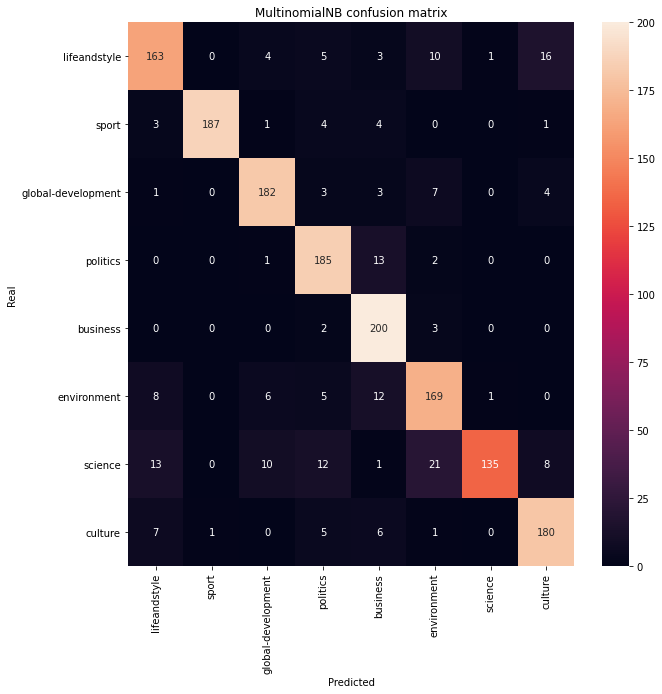

In [99]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, xticklabels=data_cat_map, yticklabels=data_cat_map, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("MultinomialNB confusion matrix")

plt.show()

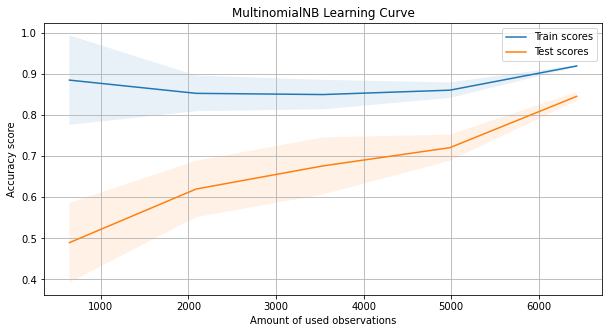

In [112]:
lc_results = learning_curve(MultinomialNB(), X, y, cv=5, n_jobs=-1, random_state=123)

xlabel = lc_results[0]

mean_train_scores = np.array([ np.mean(scores) for scores in lc_results[1]])
mean_test_scores = np.array([ np.mean(scores) for scores in lc_results[2]])

std_train_scores = np.array([ np.std(scores) for scores in lc_results[1]])
std_test_scores = np.array([ np.std(scores) for scores in lc_results[2]])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x=xlabel, y=mean_train_scores, ax=ax, label="Train scores")
sns.lineplot(x=xlabel, y=mean_test_scores, ax=ax, label="Test scores")

ax.grid()
ax.fill_between(xlabel, mean_train_scores - std_train_scores,
                     mean_train_scores + std_train_scores, alpha=0.1)
ax.fill_between(xlabel, mean_test_scores - std_test_scores,
                     mean_test_scores + std_test_scores, alpha=0.1)



plt.title("MultinomialNB Learning Curve")
plt.xlabel("Amount of used observations")
plt.ylabel("Accuracy score")

plt.show()